In [ ]:
!pip install gradio scikit-image albumentations tqdm -q

print("Packages installed")

Packages installed


In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import gradio as gr
import random
import zipfile
from google.colab import drive, files
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import warnings
warnings.filterwarnings('ignore')

print("Imports completed")
print(f"OpenCV: {cv2.__version__}")
print(f"PyTorch: {torch.__version__}")
print(f"Gradio: {gr.__version__}")

Imports completed
OpenCV: 4.13.0
PyTorch: 2.9.0+cu128
Gradio: 5.50.0


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_path = '/content/drive/MyDrive/dataset.zip'
extract_path = '/content/dataset'

In [ ]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
      zip_ref.extractall(extract_path)
print("dataset extracted")
print("folders:", os.listdir(extract_path))

dataset extracted
folders: ['dataset']


In [ ]:
class Map2SatelliteDataset(Dataset):
    def __init__(self, root_dir, is_train=True, image_size=256):
        self.root_dir = root_dir
        self.is_train = is_train
        self.image_size = image_size
        self.images = []

        if os.path.exists(root_dir):
            for ext in ['.jpg', '.png', '.jpeg']:
                self.images.extend([f for f in os.listdir(root_dir) if f.lower().endswith(ext)])
            print(f"{os.path.basename(root_dir)}: {len(self.images)} images")

    def apply_mask(self, img):
        img = img.copy()
        h, w = img.shape[:2]

        x = random.randint(0, w // 2)
        y = random.randint(0, h // 2)
        rect_w = random.randint(w // 6, w // 3)
        rect_h = random.randint(h // 6, h // 3)

        img[y:y+rect_h, x:x+rect_w] = 0

        return img

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        path = os.path.join(self.root_dir, self.images[idx])
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        h, w = img.shape[:2]
        w2 = w // 2

        inp = img[:, :w2, :]
        target = img[:, w2:, :]

        inp = cv2.resize(inp, (self.image_size, self.image_size))
        target = cv2.resize(target, (self.image_size, self.image_size))

        if self.is_train and random.random() < 0.7:
            inp = self.apply_mask(inp)

        inp = torch.from_numpy(inp).permute(2, 0, 1).float() / 127.5 - 1
        target = torch.from_numpy(target).permute(2, 0, 1).float() / 127.5 - 1

        return inp, target


Loading datasets...
train: 1096 images
val: 1098 images

Train: 1096 images
Val: 1098 images


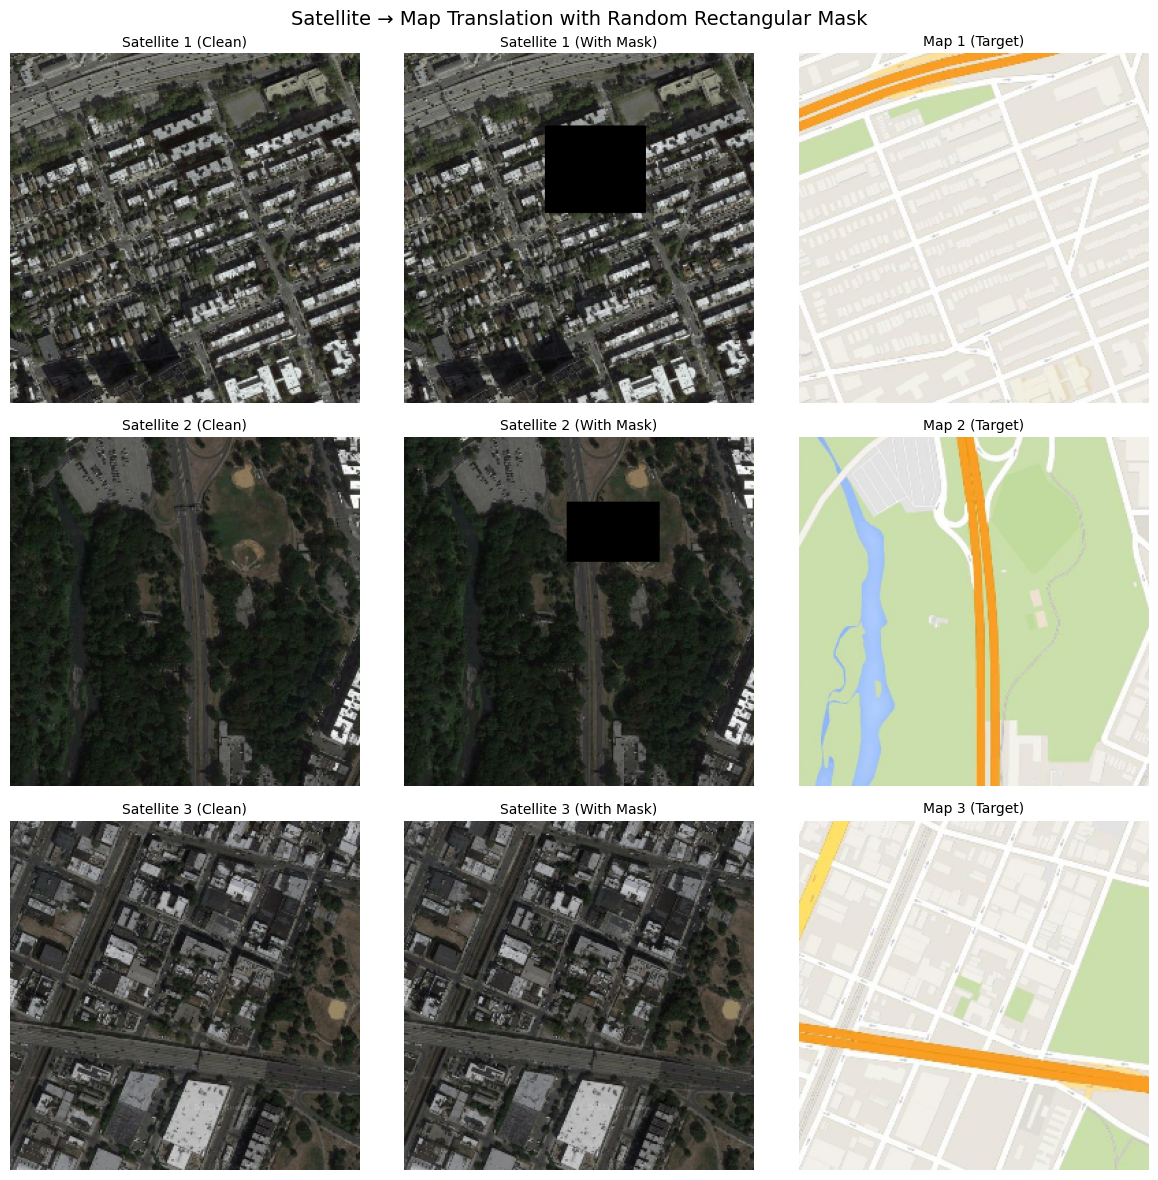

Dataset Summary:
  • Training: 1096 images (with random mask, 70% probability)
  • Validation: 1098 images (clean, no mask)
  • Image size: 256x256
  • Domain: Satellite (input) → Map (target)


In [ ]:
print("\nLoading datasets...")

base_path = '/content/dataset'
train_path = None
val_path = None

for root, dirs, files in os.walk(base_path):
    if 'train' in dirs:
        train_path = os.path.join(root, 'train')
    if 'val' in dirs or 'validation' in dirs:
        val_path = os.path.join(root, 'val') if 'val' in dirs else os.path.join(root, 'validation')

if train_path and val_path:
    train_dataset = Map2SatelliteDataset(train_path, is_train=True)
    val_dataset = Map2SatelliteDataset(val_path, is_train=False)

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

    print(f"\nTrain: {len(train_dataset)} images")
    print(f"Val: {len(val_dataset)} images")

    # ================================================
    # DISPLAY SAMPLE IMAGES
    # ================================================
    import matplotlib.pyplot as plt
    import numpy as np

    def denormalize(tensor):
        return ((tensor.cpu().numpy().transpose(1, 2, 0) + 1) * 127.5).astype(np.uint8)

    # Get samples from training set
    indices = [0, 1, 2]

    fig, axes = plt.subplots(3, 3, figsize=(12, 12))

    for i, idx in enumerate(indices):
        # Get clean version (no mask) - validation mode
        train_dataset.is_train = False
        inp_clean, target = train_dataset[idx]

        # Get masked version (with mask) - training mode
        train_dataset.is_train = True
        inp_masked, _ = train_dataset[idx]

        inp_clean_img = denormalize(inp_clean)
        inp_masked_img = denormalize(inp_masked)
        target_img = denormalize(target)

        axes[i, 0].imshow(inp_clean_img)
        axes[i, 0].set_title(f"Satellite {i+1} (Clean)", fontsize=10)
        axes[i, 0].axis('off')

        axes[i, 1].imshow(inp_masked_img)
        axes[i, 1].set_title(f"Satellite {i+1} (With Mask)", fontsize=10)
        axes[i, 1].axis('off')

        axes[i, 2].imshow(target_img)
        axes[i, 2].set_title(f"Map {i+1} (Target)", fontsize=10)
        axes[i, 2].axis('off')

    # Restore original state
    train_dataset.is_train = True

    plt.suptitle("Satellite → Map Translation with Random Rectangular Mask", fontsize=14)
    plt.tight_layout()
    plt.show()

    print("Dataset Summary:")
    print(f"  • Training: {len(train_dataset)} images (with random mask, 70% probability)")
    print(f"  • Validation: {len(val_dataset)} images (clean, no mask)")
    print(f"  • Image size: {train_dataset.image_size}x{train_dataset.image_size}")
    print(f"  • Domain: Satellite (input) → Map (target)")

else:
    print("Train/val folders not found!")
    print("Folder structure:", os.listdir(base_path))

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2)
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        )
        self.enc4 = nn.Sequential(
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2)
        )
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.Dropout(0.5),
            nn.ReLU()
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(512, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(256, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.dec4 = nn.Sequential(
            nn.ConvTranspose2d(128, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        d1 = self.dec1(e4)
        d2 = self.dec2(torch.cat([d1, e3], 1))
        d3 = self.dec3(torch.cat([d2, e2], 1))
        d4 = self.dec4(torch.cat([d3, e1], 1))
        return d4

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(6, 64, 4, 2, 1), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, 4, 1, 1), nn.Sigmoid()
        )

    def forward(self, x, y):
        return self.model(torch.cat([x, y], 1))

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nDevice: {device}")

G = Generator().to(device)
D = Discriminator().to(device)

opt_g = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_d = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

bce = nn.BCELoss()
l1 = nn.L1Loss()

print(f"Generator: {sum(p.numel() for p in G.parameters()):,} params")
print(f"Discriminator: {sum(p.numel() for p in D.parameters()):,} params")

def calculate_metrics(generator, loader, device):
    generator.eval()
    psnr_values = []
    ssim_values = []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            fake = generator(x)

            for i in range(x.shape[0]):
                fake_img = fake[i].cpu().numpy().transpose(1, 2, 0)
                real_img = y[i].cpu().numpy().transpose(1, 2, 0)

                fake_img = ((fake_img + 1) * 127.5).astype(np.uint8)
                real_img = ((real_img + 1) * 127.5).astype(np.uint8)

                psnr_val = psnr(real_img, fake_img, data_range=255)
                ssim_val = ssim(real_img, fake_img, data_range=255, channel_axis=2, win_size=11)

                psnr_values.append(psnr_val)
                ssim_values.append(ssim_val)

    return np.mean(psnr_values), np.mean(ssim_values)

print("\n" + "="*60)
print("TRAINING STARTED (50 epochs)")
print("="*60)

best_psnr = 0
metrics_history = {'train_psnr': [], 'train_ssim': [], 'val_psnr': [], 'val_ssim': []}

for epoch in range(50):
    G.train()
    D.train()
    d_losses, g_losses = [], []

    for x, y in tqdm(train_loader, desc=f'Epoch {epoch+1}/50'):
        x, y = x.to(device), y.to(device)

        fake = G(x)

        d_real = bce(D(x, y), torch.ones_like(D(x, y)))
        d_fake = bce(D(x, fake.detach()), torch.zeros_like(D(x, fake.detach())))
        d_loss = (d_real + d_fake) * 0.5

        opt_d.zero_grad()
        d_loss.backward()
        opt_d.step()

        g_gan = bce(D(x, fake), torch.ones_like(D(x, fake)))
        g_l1 = l1(fake, y) * 100
        g_loss = g_gan + g_l1

        opt_g.zero_grad()
        g_loss.backward()
        opt_g.step()

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

    avg_d_loss = np.mean(d_losses)
    avg_g_loss = np.mean(g_losses)

    if (epoch + 1) % 5 == 0:
        train_psnr, train_ssim = calculate_metrics(G, train_loader, device)
        val_psnr, val_ssim = calculate_metrics(G, val_loader, device)

        metrics_history['train_psnr'].append(train_psnr)
        metrics_history['train_ssim'].append(train_ssim)
        metrics_history['val_psnr'].append(val_psnr)
        metrics_history['val_ssim'].append(val_ssim)

        print(f"\nEpoch {epoch+1}:")
        print(f"  D Loss: {avg_d_loss:.3f}, G Loss: {avg_g_loss:.3f}")
        print(f"  Train - PSNR: {train_psnr:.2f} dB, SSIM: {train_ssim:.4f}")
        print(f"  Val   - PSNR: {val_psnr:.2f} dB, SSIM: {val_ssim:.4f}")

        if val_psnr > best_psnr:
            best_psnr = val_psnr
            torch.save(G.state_dict(), '/content/generator_best.pth')
            print(f"  New best model! Validation PSNR: {val_psnr:.2f} dB")
    else:
        print(f"Epoch {epoch+1}: D={avg_d_loss:.3f}, G={avg_g_loss:.3f}")

    if (epoch + 1) % 10 == 0:
        torch.save({
            'epoch': epoch,
            'generator_state_dict': G.state_dict(),
            'discriminator_state_dict': D.state_dict(),
            'optimizer_g_state_dict': opt_g.state_dict(),
            'optimizer_d_state_dict': opt_d.state_dict(),
            'best_psnr': best_psnr,
            'metrics_history': metrics_history
        }, f'/content/checkpoint_epoch_{epoch+1}.pth')
        print(f"Checkpoint saved at epoch {epoch+1}")

torch.save(G.state_dict(), '/content/generator_final.pth')
print("\nFinal model saved!")

!mkdir -p /content/drive/MyDrive/pix2pix_models
torch.save(G.state_dict(), '/content/drive/MyDrive/pix2pix_models/generator_final.pth')
torch.save(D.state_dict(), '/content/drive/MyDrive/pix2pix_models/discriminator_final.pth')

import json
model_info = {
    'best_psnr': float(best_psnr),
    'final_train_psnr': float(metrics_history['train_psnr'][-1]) if metrics_history['train_psnr'] else 0,
    'final_val_psnr': float(metrics_history['val_psnr'][-1]) if metrics_history['val_psnr'] else 0,
    'final_train_ssim': float(metrics_history['train_ssim'][-1]) if metrics_history['train_ssim'] else 0,
    'final_val_ssim': float(metrics_history['val_ssim'][-1]) if metrics_history['val_ssim'] else 0,
    'epochs': 50,
    'batch_size': 8,
    'generator_params': sum(p.numel() for p in G.parameters()),
    'discriminator_params': sum(p.numel() for p in D.parameters())
}

with open('/content/drive/MyDrive/pix2pix_models/model_info.json', 'w') as f:
    json.dump(model_info, f, indent=2)

print("\nModel info saved to Google Drive")
print("\n" + "="*60)
print("FINAL MODEL EVALUATION")
print("="*60)
print(f"Best Validation PSNR: {best_psnr:.2f} dB")
if metrics_history['train_psnr']:
    print(f"Final Train PSNR: {metrics_history['train_psnr'][-1]:.2f} dB")
    print(f"Final Val PSNR: {metrics_history['val_psnr'][-1]:.2f} dB")
    print(f"Final Train SSIM: {metrics_history['train_ssim'][-1]:.4f}")
    print(f"Final Val SSIM: {metrics_history['val_ssim'][-1]:.4f}")
print("="*60)
print("\nModel saved to: /content/drive/MyDrive/pix2pix_models/")


Device: cuda
Generator: 6,173,699 params
Discriminator: 2,769,601 params

TRAINING STARTED (50 epochs)


Epoch 1/50: 100%|██████████| 137/137 [00:34<00:00,  4.00it/s]


Epoch 1: D=0.343, G=23.676


Epoch 2/50: 100%|██████████| 137/137 [00:35<00:00,  3.91it/s]


Epoch 2: D=0.515, G=12.759


Epoch 3/50: 100%|██████████| 137/137 [00:39<00:00,  3.51it/s]


Epoch 3: D=0.413, G=12.684


Epoch 4/50: 100%|██████████| 137/137 [00:41<00:00,  3.27it/s]


Epoch 4: D=0.363, G=13.187


Epoch 5/50: 100%|██████████| 137/137 [00:39<00:00,  3.43it/s]



Epoch 5:
  D Loss: 0.401, G Loss: 13.018
  Train - PSNR: 22.34 dB, SSIM: 0.4618
  Val   - PSNR: 24.03 dB, SSIM: 0.4476
  New best model! Validation PSNR: 24.03 dB


Epoch 6/50: 100%|██████████| 137/137 [00:42<00:00,  3.21it/s]


Epoch 6: D=0.375, G=12.794


Epoch 7/50: 100%|██████████| 137/137 [00:39<00:00,  3.44it/s]


Epoch 7: D=0.349, G=12.683


Epoch 8/50: 100%|██████████| 137/137 [00:41<00:00,  3.30it/s]


Epoch 8: D=0.295, G=12.683


Epoch 9/50: 100%|██████████| 137/137 [00:40<00:00,  3.37it/s]


Epoch 9: D=0.329, G=12.485


Epoch 10/50: 100%|██████████| 137/137 [00:40<00:00,  3.38it/s]



Epoch 10:
  D Loss: 0.358, G Loss: 12.003
  Train - PSNR: 20.99 dB, SSIM: 0.4615
  Val   - PSNR: 23.70 dB, SSIM: 0.4907
Checkpoint saved at epoch 10


Epoch 11/50: 100%|██████████| 137/137 [00:42<00:00,  3.23it/s]


Epoch 11: D=0.394, G=12.005


Epoch 12/50: 100%|██████████| 137/137 [00:39<00:00,  3.45it/s]


Epoch 12: D=0.396, G=11.365


Epoch 13/50: 100%|██████████| 137/137 [00:41<00:00,  3.31it/s]


Epoch 13: D=0.364, G=11.295


Epoch 14/50: 100%|██████████| 137/137 [00:40<00:00,  3.38it/s]


Epoch 14: D=0.371, G=11.465


Epoch 15/50: 100%|██████████| 137/137 [00:40<00:00,  3.35it/s]



Epoch 15:
  D Loss: 0.396, G Loss: 11.396
  Train - PSNR: 20.10 dB, SSIM: 0.5169
  Val   - PSNR: 23.39 dB, SSIM: 0.5470


Epoch 16/50: 100%|██████████| 137/137 [00:42<00:00,  3.22it/s]


Epoch 16: D=0.364, G=10.957


Epoch 17/50: 100%|██████████| 137/137 [00:39<00:00,  3.45it/s]


Epoch 17: D=0.266, G=12.620


Epoch 18/50: 100%|██████████| 137/137 [00:41<00:00,  3.32it/s]


Epoch 18: D=0.385, G=11.291


Epoch 19/50: 100%|██████████| 137/137 [00:40<00:00,  3.36it/s]


Epoch 19: D=0.352, G=10.895


Epoch 20/50: 100%|██████████| 137/137 [00:41<00:00,  3.33it/s]



Epoch 20:
  D Loss: 0.318, G Loss: 11.424
  Train - PSNR: 23.99 dB, SSIM: 0.5838
  Val   - PSNR: 25.14 dB, SSIM: 0.5837
  New best model! Validation PSNR: 25.14 dB
Checkpoint saved at epoch 20


Epoch 21/50: 100%|██████████| 137/137 [00:42<00:00,  3.22it/s]


Epoch 21: D=0.319, G=11.810


Epoch 22/50: 100%|██████████| 137/137 [00:39<00:00,  3.45it/s]


Epoch 22: D=0.327, G=10.914


Epoch 23/50: 100%|██████████| 137/137 [00:41<00:00,  3.33it/s]


Epoch 23: D=0.313, G=11.334


Epoch 24/50: 100%|██████████| 137/137 [00:40<00:00,  3.38it/s]


Epoch 24: D=0.294, G=11.578


Epoch 25/50: 100%|██████████| 137/137 [00:40<00:00,  3.36it/s]



Epoch 25:
  D Loss: 0.309, G Loss: 11.473
  Train - PSNR: 24.23 dB, SSIM: 0.5840
  Val   - PSNR: 24.96 dB, SSIM: 0.5811


Epoch 26/50: 100%|██████████| 137/137 [00:42<00:00,  3.23it/s]


Epoch 26: D=0.318, G=11.099


Epoch 27/50: 100%|██████████| 137/137 [00:39<00:00,  3.45it/s]


Epoch 27: D=0.271, G=11.355


Epoch 28/50: 100%|██████████| 137/137 [00:41<00:00,  3.32it/s]


Epoch 28: D=0.231, G=12.224


Epoch 29/50: 100%|██████████| 137/137 [00:40<00:00,  3.38it/s]


Epoch 29: D=0.189, G=12.700


Epoch 30/50: 100%|██████████| 137/137 [00:40<00:00,  3.38it/s]



Epoch 30:
  D Loss: 0.149, G Loss: 12.707
  Train - PSNR: 23.10 dB, SSIM: 0.5845
  Val   - PSNR: 24.57 dB, SSIM: 0.5795
Checkpoint saved at epoch 30


Epoch 31/50: 100%|██████████| 137/137 [00:42<00:00,  3.23it/s]


Epoch 31: D=0.205, G=12.484


Epoch 32/50: 100%|██████████| 137/137 [00:39<00:00,  3.46it/s]


Epoch 32: D=0.214, G=12.726


Epoch 33/50: 100%|██████████| 137/137 [00:41<00:00,  3.32it/s]


Epoch 33: D=0.131, G=13.488


Epoch 34/50: 100%|██████████| 137/137 [00:40<00:00,  3.39it/s]


Epoch 34: D=0.047, G=14.213


Epoch 35/50: 100%|██████████| 137/137 [00:40<00:00,  3.37it/s]



Epoch 35:
  D Loss: 0.183, G Loss: 13.582
  Train - PSNR: 24.65 dB, SSIM: 0.6010
  Val   - PSNR: 25.36 dB, SSIM: 0.5969
  New best model! Validation PSNR: 25.36 dB


Epoch 36/50: 100%|██████████| 137/137 [00:42<00:00,  3.23it/s]


Epoch 36: D=0.082, G=14.005


Epoch 37/50: 100%|██████████| 137/137 [00:39<00:00,  3.45it/s]


Epoch 37: D=0.082, G=14.627


Epoch 38/50: 100%|██████████| 137/137 [00:41<00:00,  3.30it/s]


Epoch 38: D=0.287, G=12.543


Epoch 39/50: 100%|██████████| 137/137 [00:40<00:00,  3.39it/s]


Epoch 39: D=0.080, G=13.934


Epoch 40/50: 100%|██████████| 137/137 [00:40<00:00,  3.37it/s]



Epoch 40:
  D Loss: 0.066, G Loss: 14.509
  Train - PSNR: 23.78 dB, SSIM: 0.5735
  Val   - PSNR: 24.95 dB, SSIM: 0.5791
Checkpoint saved at epoch 40


Epoch 41/50: 100%|██████████| 137/137 [00:42<00:00,  3.21it/s]


Epoch 41: D=0.140, G=14.308


Epoch 42/50: 100%|██████████| 137/137 [00:39<00:00,  3.46it/s]


Epoch 42: D=0.026, G=15.071


Epoch 43/50: 100%|██████████| 137/137 [00:41<00:00,  3.31it/s]


Epoch 43: D=0.196, G=14.728


Epoch 44/50: 100%|██████████| 137/137 [00:40<00:00,  3.38it/s]


Epoch 44: D=0.132, G=13.607


Epoch 45/50: 100%|██████████| 137/137 [00:40<00:00,  3.37it/s]



Epoch 45:
  D Loss: 0.039, G Loss: 14.414
  Train - PSNR: 24.44 dB, SSIM: 0.6079
  Val   - PSNR: 25.16 dB, SSIM: 0.5988


Epoch 46/50: 100%|██████████| 137/137 [00:42<00:00,  3.21it/s]


Epoch 46: D=0.037, G=15.911


Epoch 47/50: 100%|██████████| 137/137 [00:39<00:00,  3.46it/s]


Epoch 47: D=0.237, G=13.619


Epoch 48/50: 100%|██████████| 137/137 [00:41<00:00,  3.32it/s]


Epoch 48: D=0.051, G=14.226


Epoch 49/50: 100%|██████████| 137/137 [00:40<00:00,  3.37it/s]


Epoch 49: D=0.150, G=14.157


Epoch 50/50: 100%|██████████| 137/137 [00:41<00:00,  3.34it/s]



Epoch 50:
  D Loss: 0.124, G Loss: 13.064
  Train - PSNR: 24.44 dB, SSIM: 0.6089
  Val   - PSNR: 25.06 dB, SSIM: 0.6036
Checkpoint saved at epoch 50

Final model saved!

Model info saved to Google Drive

FINAL MODEL EVALUATION
Best Validation PSNR: 25.36 dB
Final Train PSNR: 24.44 dB
Final Val PSNR: 25.06 dB
Final Train SSIM: 0.6089
Final Val SSIM: 0.6036

Model saved to: /content/drive/MyDrive/pix2pix_models/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import torch
import json

# Create directory
!mkdir -p /content/drive/MyDrive/pix2pix_models

# Save generator
torch.save(G.state_dict(), '/content/drive/MyDrive/pix2pix_models/generator_final.pth')
print("Generator saved")

# Save discriminator (optional)
torch.save(D.state_dict(), '/content/drive/MyDrive/pix2pix_models/discriminator_final.pth')
print("Discriminator saved")

# Save model info with updated metrics
model_info = {
    'best_psnr': float(best_psnr),
    'final_train_psnr': float(metrics_history['train_psnr'][-1]) if metrics_history['train_psnr'] else 0,
    'final_val_psnr': float(metrics_history['val_psnr'][-1]) if metrics_history['val_psnr'] else 0,
    'final_train_ssim': float(metrics_history['train_ssim'][-1]) if metrics_history['train_ssim'] else 0,
    'final_val_ssim': float(metrics_history['val_ssim'][-1]) if metrics_history['val_ssim'] else 0,
    'epochs': 50,
    'batch_size': 8,
    'generator_params': sum(p.numel() for p in G.parameters()),
    'discriminator_params': sum(p.numel() for p in D.parameters())
}

with open('/content/drive/MyDrive/pix2pix_models/model_info.json', 'w') as f:
    json.dump(model_info, f, indent=2)
print("Model info saved")

print("\nFiles saved to: /content/drive/MyDrive/pix2pix_models/")
!ls -la /content/drive/MyDrive/pix2pix_models/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Generator saved
Discriminator saved
Model info saved

Files saved to: /content/drive/MyDrive/pix2pix_models/
total 34978
-rw------- 1 root root 11094604 Feb 13 08:32 discriminator_final.pth
-rw------- 1 root root 24721401 Feb 13 08:32 generator_final.pth
-rw------- 1 root root      301 Feb 13 08:32 model_info.json


In [ ]:
# ================================================
# GRADIO UI - LOAD MODEL FROM DRIVE
# ================================================

import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import gradio as gr
import random
import json
from google.colab import drive
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# ================================================
# 1. MOUNT DRIVE AND LOAD MODEL
# ================================================

drive.mount('/content/drive')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# ================================================
# 2. DEFINE GENERATOR ARCHITECTURE (SAME AS TRAINING)
# ================================================

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2)
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        )
        self.enc4 = nn.Sequential(
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2)
        )
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.Dropout(0.5),
            nn.ReLU()
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(512, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(256, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.dec4 = nn.Sequential(
            nn.ConvTranspose2d(128, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        d1 = self.dec1(e4)
        d2 = self.dec2(torch.cat([d1, e3], 1))
        d3 = self.dec3(torch.cat([d2, e2], 1))
        d4 = self.dec4(torch.cat([d3, e1], 1))
        return d4

# ================================================
# 3. LOAD MODEL WEIGHTS FROM DRIVE
# ================================================

model_path = '/content/drive/MyDrive/pix2pix_models/generator_final.pth'
info_path = '/content/drive/MyDrive/pix2pix_models/model_info.json'

with open(info_path, 'r') as f:
    model_info = json.load(f)

print(f"Model Info:")
print(f"  Best Validation PSNR: {model_info['best_psnr']:.2f} dB")
print(f"  Final Train PSNR: {model_info['final_train_psnr']:.2f} dB")
print(f"  Final Val PSNR: {model_info['final_val_psnr']:.2f} dB")
print(f"  Final Val SSIM: {model_info['final_val_ssim']:.4f}")
print(f"  Epochs: {model_info['epochs']}")
print(f"  Generator Params: {model_info['generator_params']:,}")

G = Generator().to(device)
G.load_state_dict(torch.load(model_path, map_location=device))
G.eval()
print(f"Model loaded from: {model_path}")

# ================================================
# 4. CREATE EXAMPLE IMAGES FROM VALIDATION SET
# ================================================

def create_example_images():
    example_images = []
    example_labels = []

    indices = random.sample(range(len(val_dataset)), min(5, len(val_dataset)))

    for i, idx in enumerate(indices):
        inp, target = val_dataset[idx]
        img = inp.cpu().numpy().transpose(1, 2, 0)
        img = ((img + 1) * 127.5).astype(np.uint8)

        x = random.randint(0, img.shape[1] // 2)
        y = random.randint(0, img.shape[0] // 2)
        rect_w = random.randint(img.shape[1] // 6, img.shape[1] // 3)
        rect_h = random.randint(img.shape[0] // 6, img.shape[0] // 3)

        img_mask = img.copy()
        img_mask[y:y+rect_h, x:x+rect_w] = 0

        example_images.append(img_mask)
        example_labels.append(f"Mask {i+1}")

    return example_images, example_labels

# ================================================
# 5. PROCESSING FUNCTION
# ================================================

def process_image(input_img, apply_mask, mask_intensity):
    if input_img is None:
        return None, None, "Please upload an image", "", ""

    img = cv2.resize(input_img, (256, 256))
    original_img = img.copy()

    if apply_mask:
        h, w = img.shape[:2]
        x = random.randint(0, w // 2)
        y = random.randint(0, h // 2)
        rect_w = random.randint(int(w // 6 * mask_intensity), int(w // 3 * mask_intensity))
        rect_h = random.randint(int(h // 6 * mask_intensity), int(h // 3 * mask_intensity))
        rect_w = max(10, rect_w)
        rect_h = max(10, rect_h)
        img[y:y+rect_h, x:x+rect_w] = 0

    img_tensor = torch.from_numpy(img).permute(2, 0, 1).float() / 127.5 - 1
    img_tensor = img_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        output = G(img_tensor)

    output = output[0].cpu().permute(1, 2, 0).numpy()
    output = ((output + 1) * 127.5).astype(np.uint8)

    psnr_val = psnr(original_img, output, data_range=255)
    ssim_val = ssim(original_img, output, data_range=255, channel_axis=2, win_size=11)

    metrics_text = f"PSNR: {psnr_val:.2f} dB | SSIM: {ssim_val:.4f}"
    quality_text = "Excellent" if psnr_val > 30 else "Good" if psnr_val > 25 else "Fair"

    return img, output, "Success!", metrics_text, quality_text

def set_example_image(img):
    return img

# ================================================
# 6. CREATE EXAMPLE IMAGES
# ================================================

print("\nCreating example images for UI demo...")
example_images, example_labels = create_example_images()
print(f"Created {len(example_images)} example images")

# ================================================
# 7. BUILD GRADIO INTERFACE
# ================================================

with gr.Blocks(title="Satellite to Map Translation", theme=gr.themes.Soft()) as demo:
    gr.Markdown(f"""
    # Satellite to Map Translation

    ### Computer Vision Final Project
    **Image Translation with GAN + Rectangular Mask + Evaluation**

    ---
    **Model loaded from Google Drive**
    **Best Validation PSNR: {model_info['best_psnr']:.2f} dB**
    **Final Validation SSIM: {model_info['final_val_ssim']:.4f}**
    **Trained for {model_info['epochs']} epochs**
    """)

    with gr.Tab("Single Image Translation"):
        with gr.Row():
            with gr.Column():
                input_img = gr.Image(label="Upload Satellite Image", type="numpy")

                with gr.Row():
                    apply_mask = gr.Checkbox(label="Apply Random Mask", value=True)
                    mask_intensity = gr.Slider(0.5, 1.5, 1.0, label="Mask Size")

                btn = gr.Button("Generate Map", variant="primary")

                gr.Markdown("### Try these examples:")
                with gr.Row():
                    for i, (img, label) in enumerate(zip(example_images, example_labels)):
                        with gr.Column():
                            gr.Image(value=img, label=label, height=150, width=150)
                            example_btn = gr.Button(f"Example {i+1}", size="sm")
                            example_btn.click(
                                fn=set_example_image,
                                inputs=[gr.State(img)],
                                outputs=[input_img]
                            )

            with gr.Column():
                with gr.Row():
                    with gr.Column():
                        gr.Markdown("### Input")
                        input_display = gr.Image(label="Satellite")
                    with gr.Column():
                        gr.Markdown("### Output")
                        output_display = gr.Image(label="Generated Map")

                status = gr.Textbox(label="Status")
                metrics_display = gr.Textbox(label="Metrics")
                quality_display = gr.Textbox(label="Quality")

        btn.click(
            process_image,
            inputs=[input_img, apply_mask, mask_intensity],
            outputs=[input_display, output_display, status, metrics_display, quality_display]
        )

    with gr.Tab("Model Evaluation"):
        gr.Markdown(f"""
        ### Performance Metrics

        | Metric | Value |
        |--------|-------|
        | Best Validation PSNR | {model_info['best_psnr']:.2f} dB |
        | Final Train PSNR | {model_info['final_train_psnr']:.2f} dB |
        | Final Validation PSNR | {model_info['final_val_psnr']:.2f} dB |
        | Final Validation SSIM | {model_info['final_val_ssim']:.4f} |
        | Training Epochs | {model_info['epochs']} |
        | Batch Size | {model_info['batch_size']} |
        | Generator Parameters | {model_info['generator_params']:,} |

        ---
        ### Distortion Type
        - **Random Rectangular Mask**: Black rectangle placed randomly on the satellite image
        - Mask size and position vary during training (70% probability)
        - Validation uses clean images with no mask
        """)

    with gr.Tab("Project Info"):
        gr.Markdown(f"""
        ### Architecture
        - **Generator:** U-Net with skip connections
        - **Discriminator:** PatchGAN
        - **Loss:** GAN Loss + L1 Loss (λ=100)

        ### Training Details
        - **Domain:** Satellite (input) → Map (target)
        - **Dataset:** {len(val_dataset)} validation images
        - **Epochs:** {model_info['epochs']}
        - **Batch Size:** {model_info['batch_size']}
        - **Optimizer:** Adam (lr=0.0002, β1=0.5, β2=0.999)

        ### Features
        1. **Random rectangular mask** applied during training
        2. **Real-time PSNR/SSIM** metrics
        3. **5 example images** from validation set
        4. **Mask intensity control** in UI
        5. **Model persistence** - loaded from Google Drive
        """)

# ================================================
# 8. LAUNCH UI
# ================================================

print("\n" + "="*60)
print("Launching UI with loaded model...")
print("="*60)
print(f"Model: {model_info['best_psnr']:.2f} dB Best Validation PSNR")
print(f"Domain: Satellite (input) → Map (target)")
print(f"Distortion: Random rectangular mask")
for i, label in enumerate(example_labels):
    print(f"  Example {i+1}: {label}")
print("="*60)

demo.launch(share=True, debug=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Device: cuda
Model Info:
  Best Validation PSNR: 25.36 dB
  Final Train PSNR: 24.44 dB
  Final Val PSNR: 25.06 dB
  Final Val SSIM: 0.6036
  Epochs: 50
  Generator Params: 6,173,699
Model loaded from: /content/drive/MyDrive/pix2pix_models/generator_final.pth

Creating example images for UI demo...
Created 5 example images

Launching UI with loaded model...
Model: 25.36 dB Best Validation PSNR
Domain: Satellite (input) → Map (target)
Distortion: Random rectangular mask
  Example 1: Mask 1
  Example 2: Mask 2
  Example 3: Mask 3
  Example 4: Mask 4
  Example 5: Mask 5
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c7f47903bac1ed7c6f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to d